# ADIOS2-Python-High-Level-MPI: Write Read Cooling Rod 1D



## Writer: Generate Data
    
    We use a simple solution to the heat transfer equation in a (very-fast) 1D cooling rod.
    

In [7]:
from mpi4py import MPI
import math
import numpy as np
import adios2


def calcUxt(Uo, x, t):
    return 4 * Uo / math.pi * math.sin(math.pi * x) * math.exp(- math.pi * math.pi * t)

# Initialize MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Initialize dimensions
nx = 10

shape = [size * nx]
start = [rank * nx]
count = [   1 * nx]

# Initialize problem x coord, Uo, Uxt
Lx = 1. 
Dx = 1./shape[0]
x = np.full( (nx), 0. )
for i in range(0,nx):
    x[i] = start[0] + (i+0.5) * Dx

# Make sure you use floats
Uo = 1. 
Uxt = np.full( (nx), Uo)

# Writer
with adios2.open("Uxt.bp", "w", comm) as fw:

    for t in range(0, 5):
        # We save "x" only once
        if(t == 0):
            fw.write("x", x, shape, start, count)
        else:
            for i in range(0,nx):
                Uxt[i] = calcUxt(Uo, x[i], t)
                
        fw.write("Uxt", Uxt, shape, start, count, end_step=True)

The data is saved in a bp file and subsfile directory structure. To access the data, the user doesn't need to manipulate these directly, but rather using the **bpls** command line utility for quick inspection. For example:

In [8]:
!bpls Uxt.bp -lavd -n 10

File info:
  of variables:  2
  of attributes: 0
  statistics:    Min / Max 

  double   Uxt   5*{10} = 1.42555e-18 / 1
    (0,0)    1 1 1 1 1 1 1 1 1 1
    (1,0)    1.03021e-05 2.9898e-05 4.65672e-05 5.86781e-05 6.50452e-05 6.50452e-05 5.86781e-05 4.65672e-05 2.9898e-05 1.03021e-05
    (2,0)    5.3286e-10 1.54642e-09 2.40861e-09 3.03502e-09 3.36435e-09 3.36435e-09 3.03502e-09 2.40861e-09 1.54642e-09 5.3286e-10
    (3,0)    2.75612e-14 7.99858e-14 1.24581e-13 1.56981e-13 1.74015e-13 1.74015e-13 1.56981e-13 1.24581e-13 7.99858e-14 2.75612e-14
    (4,0)    1.42555e-18 4.13712e-18 6.44371e-18 8.11955e-18 9.00059e-18 9.00059e-18 8.11955e-18 6.44371e-18 4.13712e-18 1.42555e-18

  double   x     {10} = 0.05 / 0.95
    (0)    0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95



## Reader: Accessing and Understanding the Data

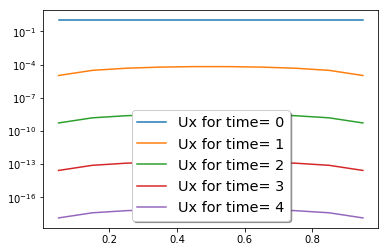

In [9]:
from mpi4py import MPI
import math
import numpy as np
import adios2
import matplotlib.pyplot as plt


Uxt_plots = plt.subplots()

with adios2.open("Uxt.bp", "r", comm) as fr:

    for fr_step in fr:

        step = fr_step.current_step()
        if(step == 0):
            x = fr_step.read("x")
            
        Uxt = fr_step.read("Uxt")
        
        plt.semilogy(x, Uxt, label = "Ux for time= " + str(step))
        
legend = plt.legend(loc='best', shadow=True, fontsize='x-large')